## 의사결정나무와 SVM을 활용한 분류 문제 해결

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt    
from IPython.display import Image
%matplotlib inline


In [2]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.2):
    # 마커와 컬러맵 설정하기
    markers=('s', 'x', 'o', '^', 'v')
    colors=('red','blue','lightgreen','gray','cyan')
    cmap=ListedColormap(colors[:len(np.unique(y))])
    
    # 결정경계를 그리기
    x1_min, x1_max = X[:,0].min()-1, X[:,0].max()+1
    x2_min, x2_max = X[:,1].min()-1, X[:,1].max()+1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl,0], y=X[y==cl,1],
                   alpha=0.8, c=colors[idx],
                   marker=markers[idx], label=cl,
                   edgecolor='black')
        
    # 테스트 샘플을 부각하여 그리기
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:,0], X_test[:,1],
                   c=colors[idx+1], edgecolor='black',alpha=1.0,
                   linewidth=1, marker='o',
                   s=100, label='test set')

## 1. 데이터셋 만들기

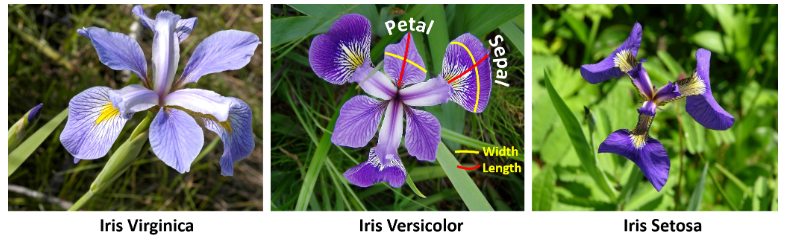

In [4]:
from sklearn import datasets
iris = datasets.load_iris()
data = iris.data #x값
data

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [5]:
X = iris.data[:, [2, 3]] # 3, 4번째 feature 만 사용
y = iris.target # iris.target: (150,) array  ,y값

print('Class labels:', np.unique(y))

print('Features names:', iris.feature_names)

Class labels: [0 1 2]
Features names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


### 데이터를 7:3 비율로 train/test split. stratify=y 로 traing과 test set의 y 비율이 같도록 맞춘다.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [9]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


### 데이터 정규화

In [10]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

print(np.mean(X_train_std), np.std(X_train_std))

1.0150610510858574e-16 0.9999999999999999


## 2. 의사결정나무 만들기

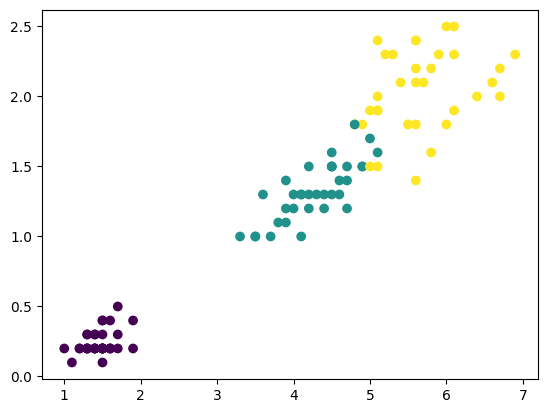

In [11]:
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)

### 분할 속성 선택 기준: entropy , max_depth=5

/tmp/ipykernel_829184/608533853.py:19: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y==cl,0], y=X[y==cl,1],


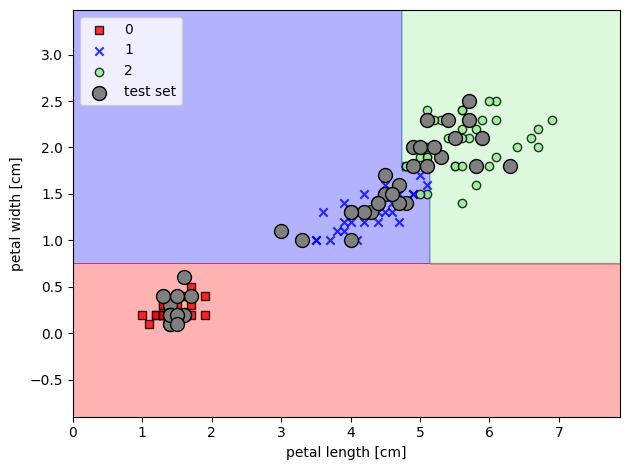

In [83]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=5, # max_depth 5로 설정했기 때문에 완벽하게 분류 안되어도 끝냄
                              random_state=1)
tree.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree , test_idx=range(105, 150), resolution=0.02)

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

/tmp/ipykernel_829184/608533853.py:19: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y==cl,0], y=X[y==cl,1],


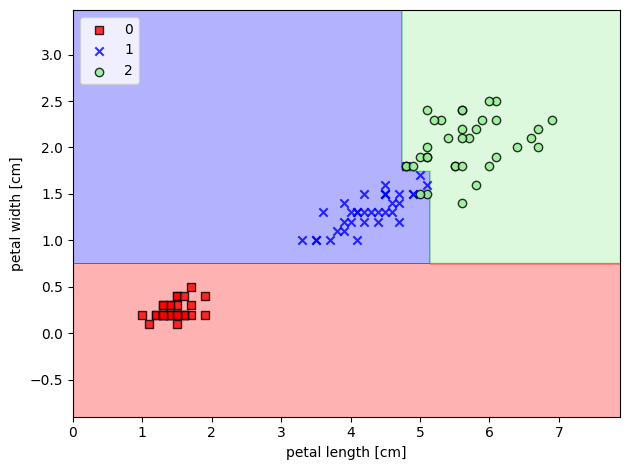

In [84]:
plot_decision_regions(X_train, y_train, 
                      classifier=tree , resolution=0.02)

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

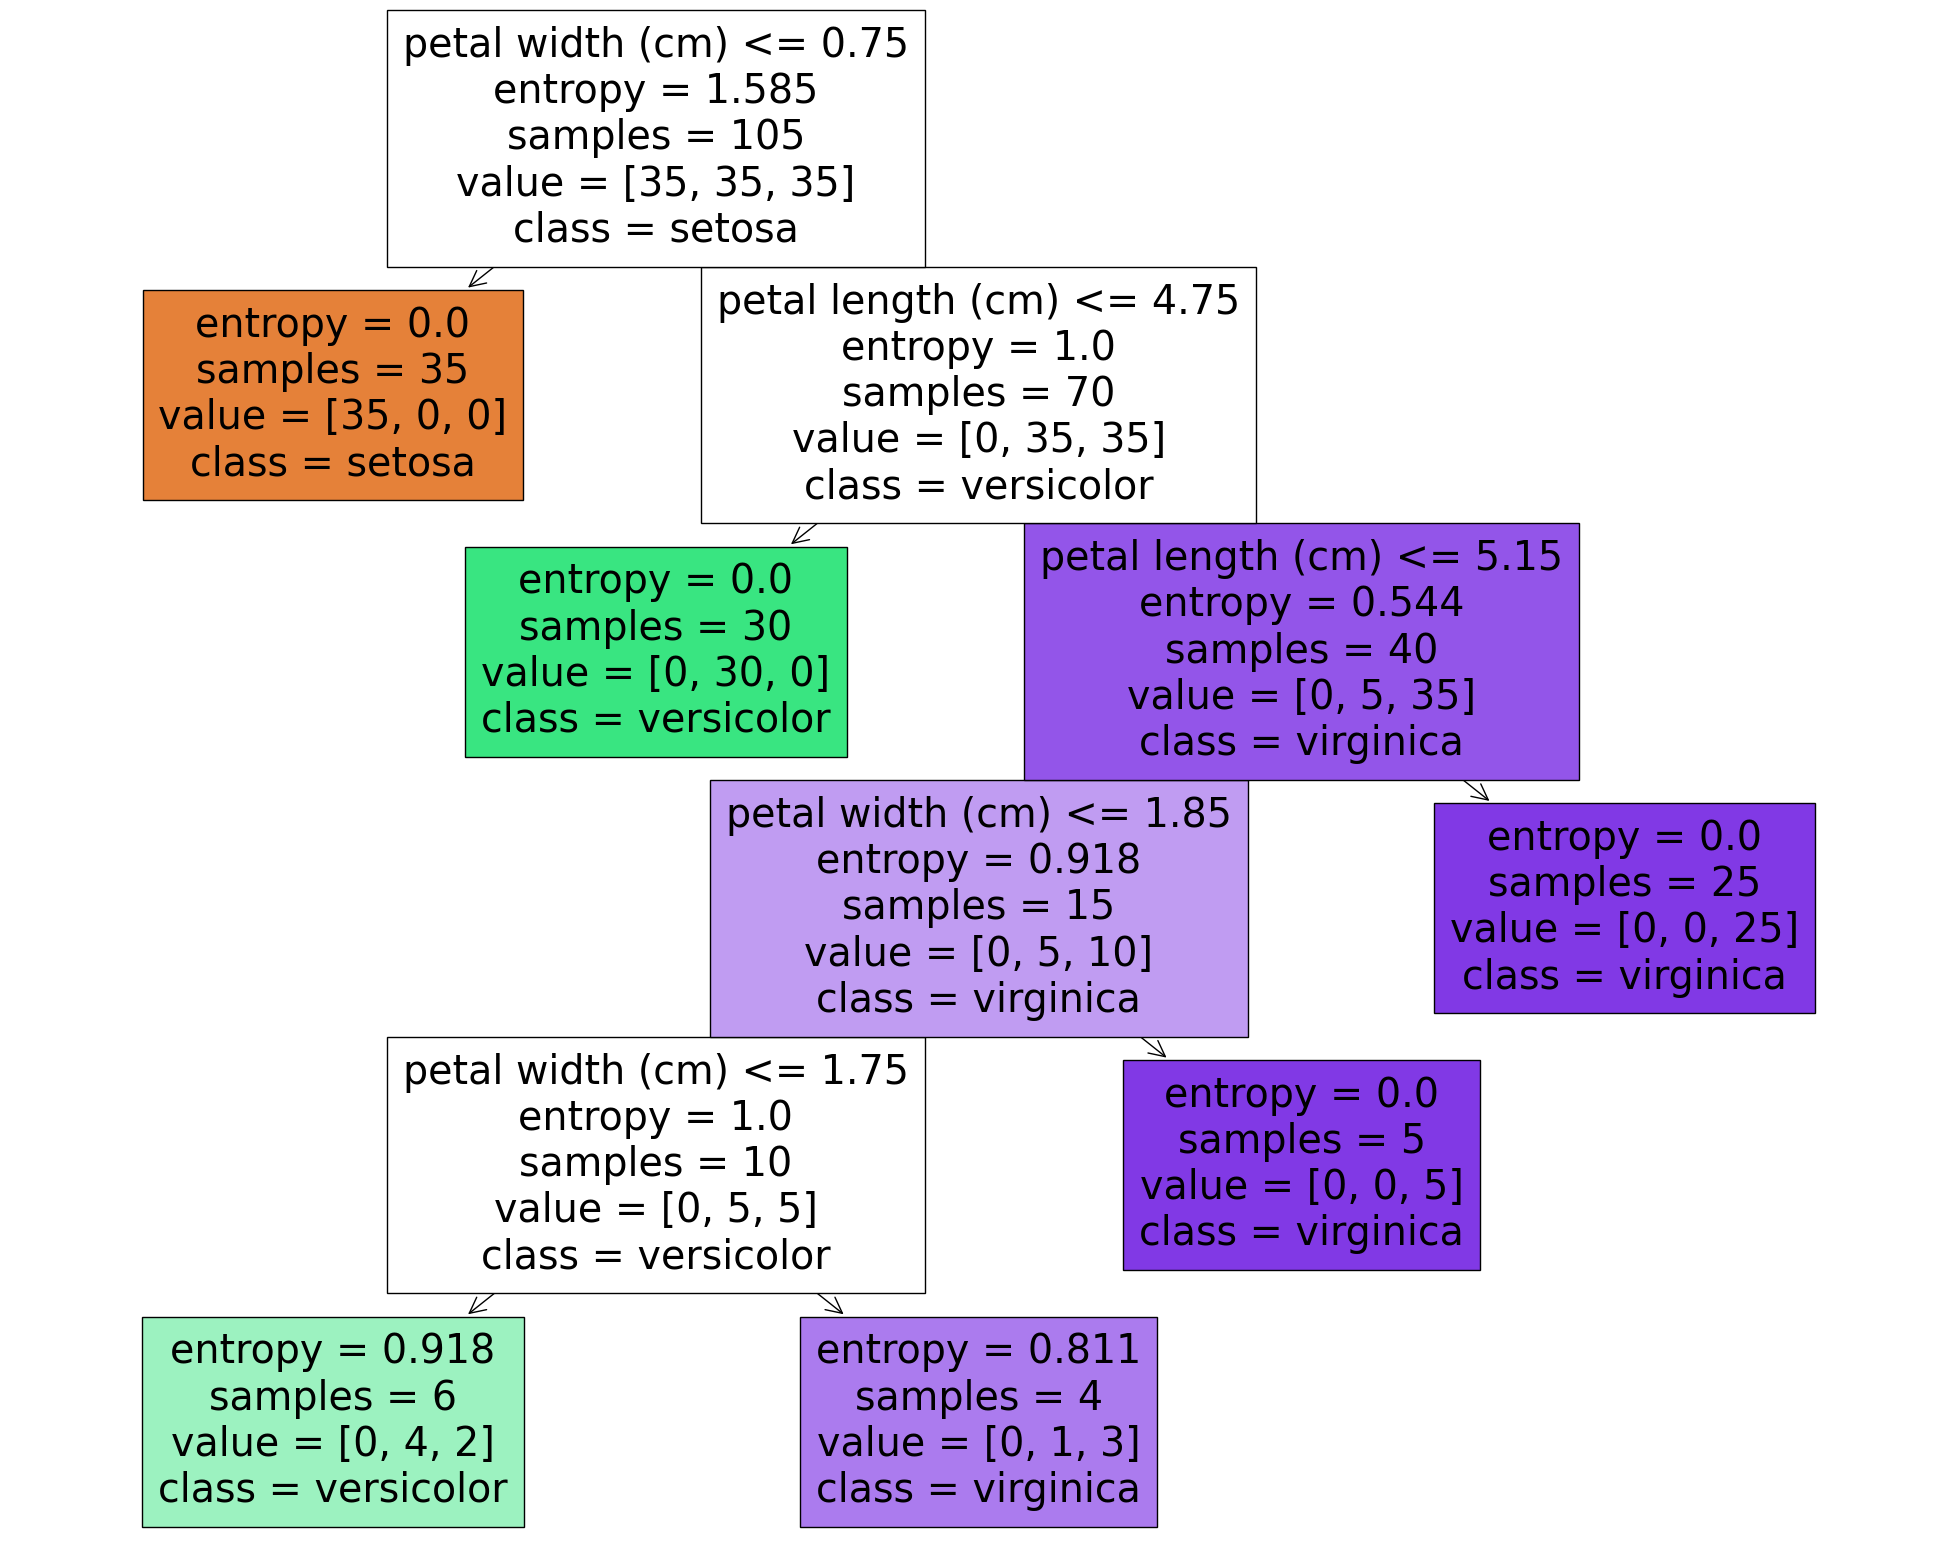

In [65]:
from sklearn.tree import plot_tree
fig = plt.figure(figsize=(25,20))
_ = plot_tree(tree, 
                   feature_names=iris.feature_names[2:],  
                   class_names=iris.target_names,
                   filled=True)

### max_depth=10

/tmp/ipykernel_829184/608533853.py:19: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y==cl,0], y=X[y==cl,1],


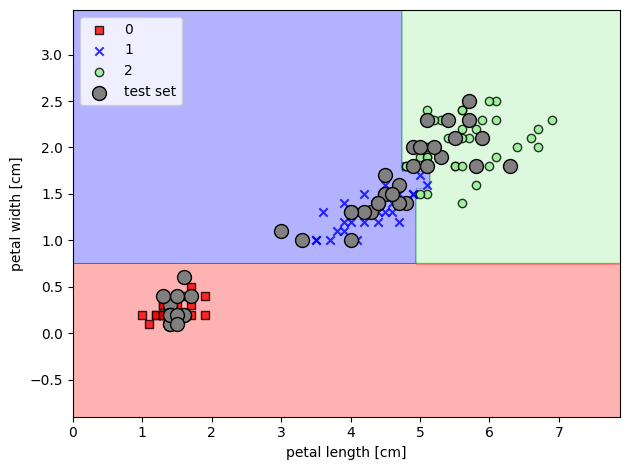

In [81]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=10, 
                              random_state=1)
tree.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree, test_idx=range(105, 150) , resolution=0.02)

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

/tmp/ipykernel_829184/608533853.py:19: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y==cl,0], y=X[y==cl,1],


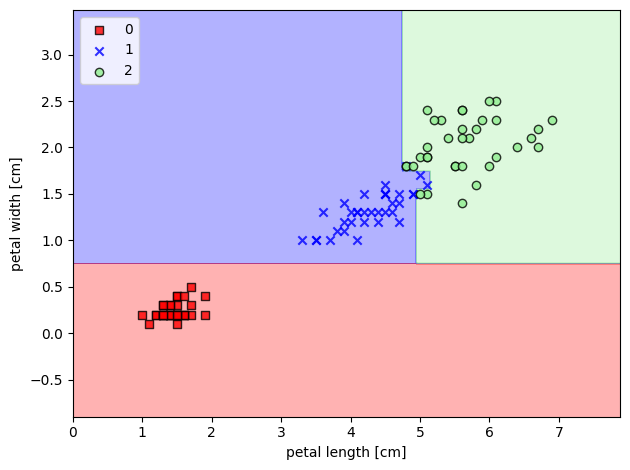

In [82]:
plot_decision_regions(X_train, y_train, 
                      classifier=tree , resolution=0.02)

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

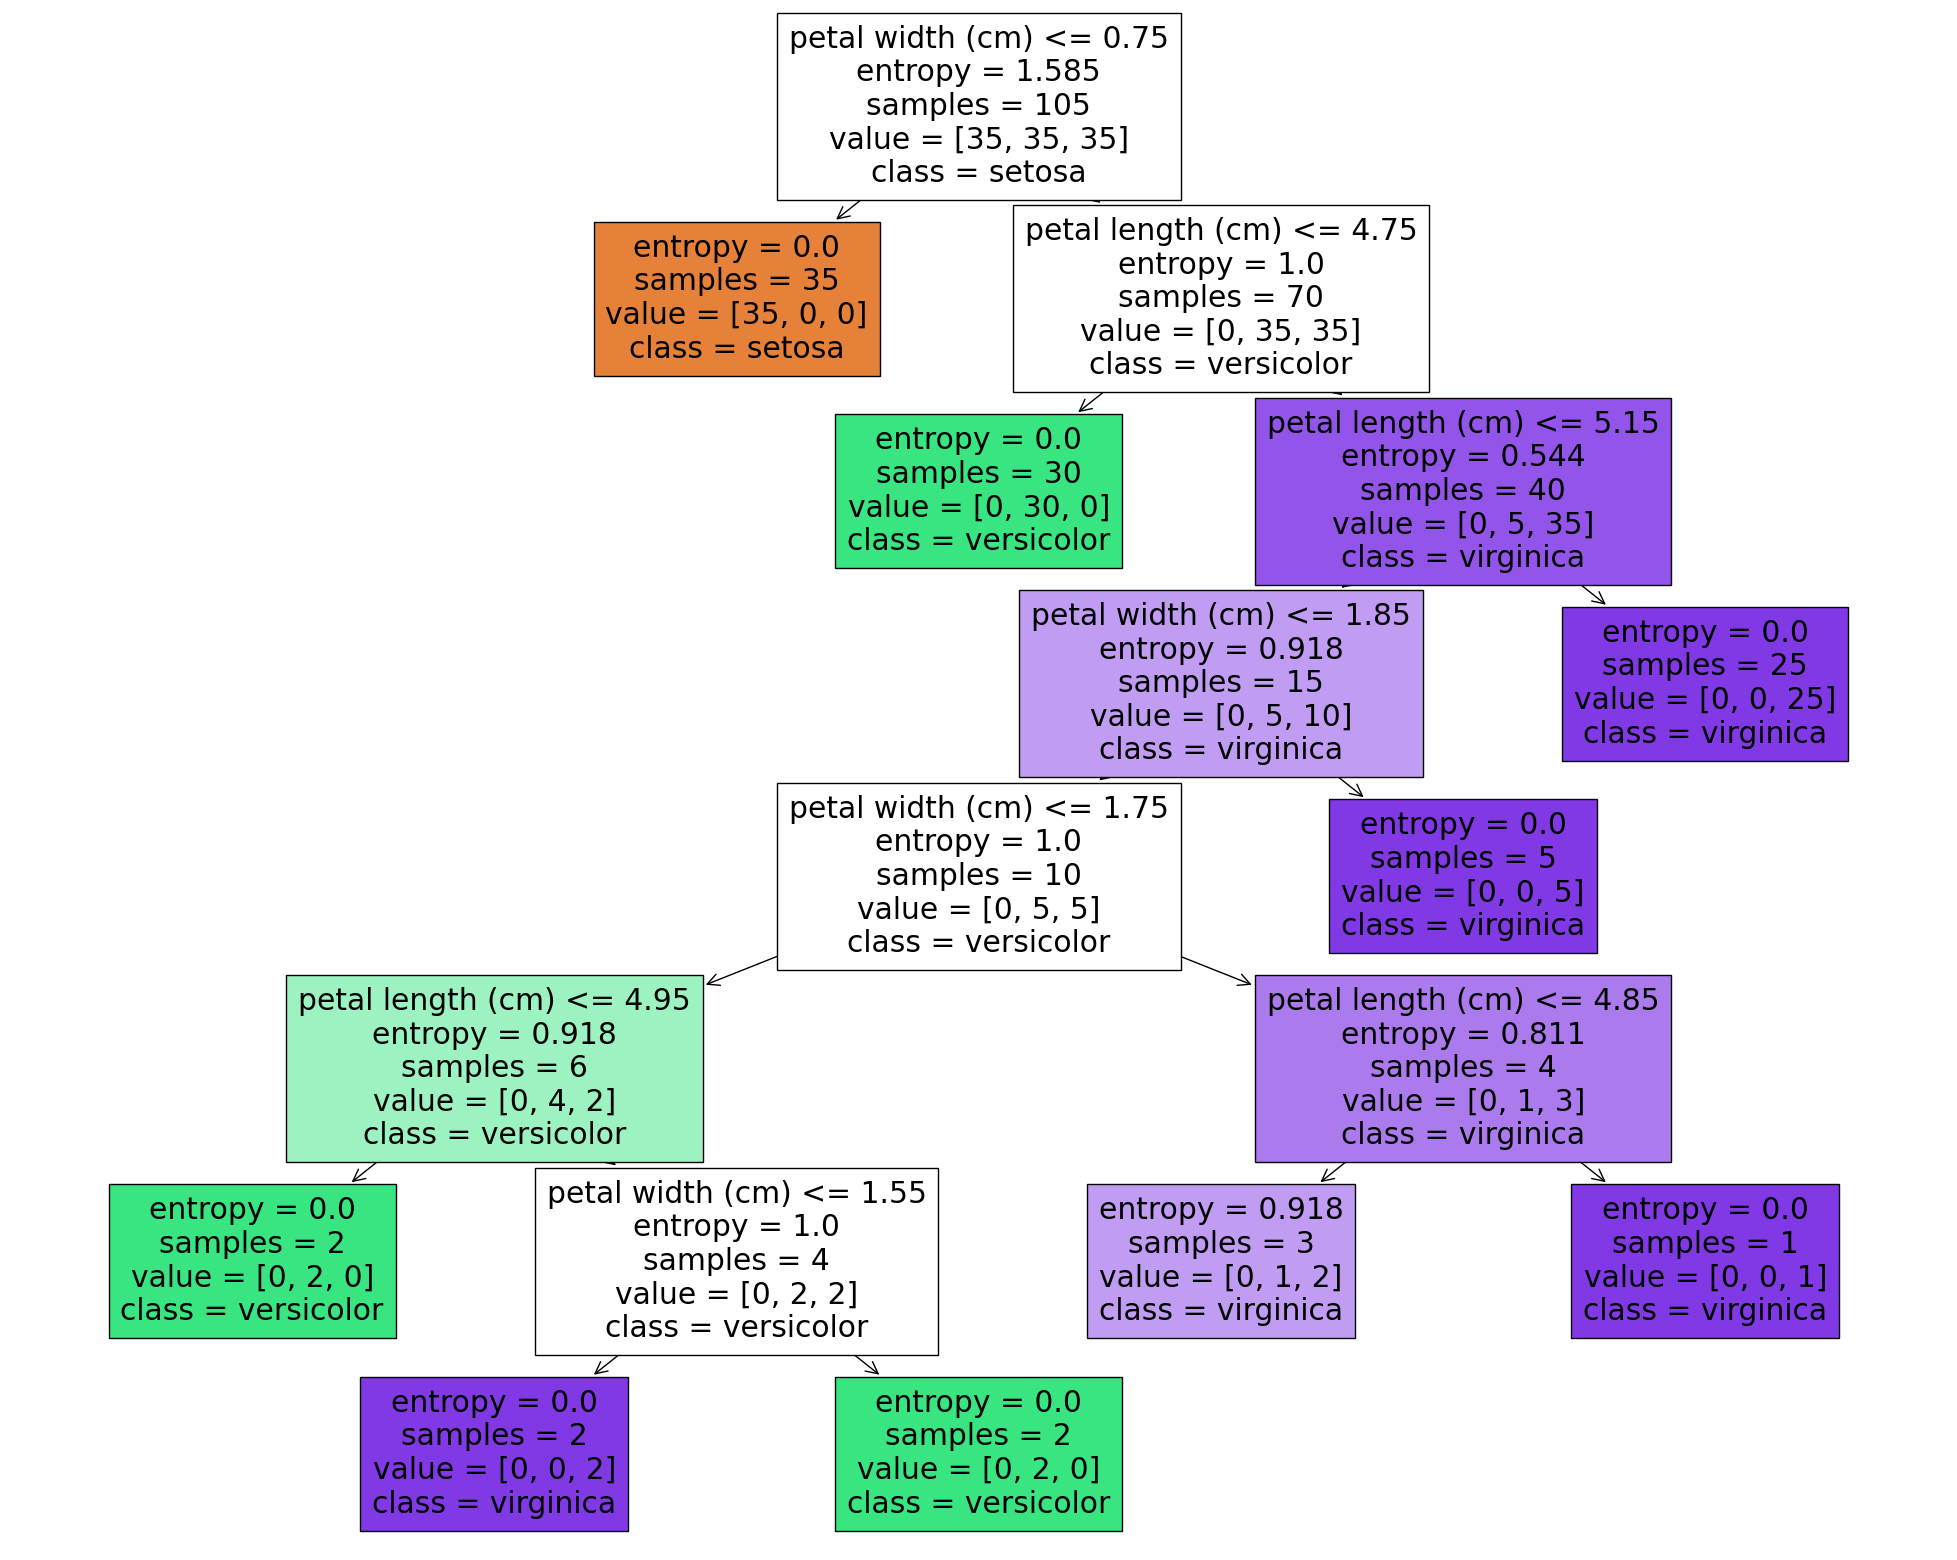

In [75]:
from sklearn.tree import plot_tree
fig = plt.figure(figsize=(25,20))
_ = plot_tree(tree, 
                   feature_names=iris.feature_names[2:],  
                   class_names=iris.target_names,
                   filled=True)

### 분할 속성 선택 기준: gini, max_depth=3

/tmp/ipykernel_829184/608533853.py:19: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y==cl,0], y=X[y==cl,1],


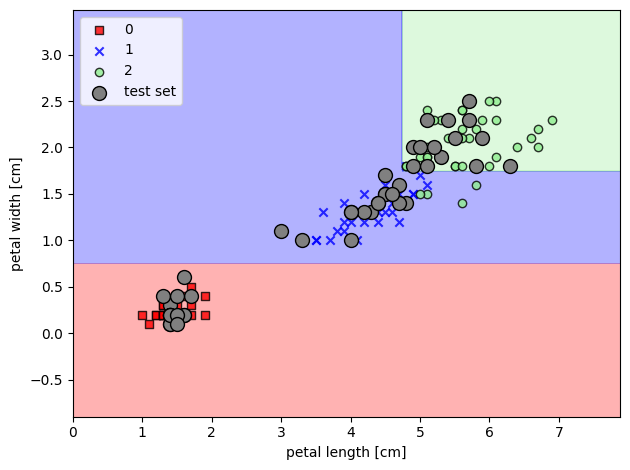

In [90]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=3, 
                              random_state=1)
tree.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree, test_idx=range(105, 150), resolution=0.02)

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

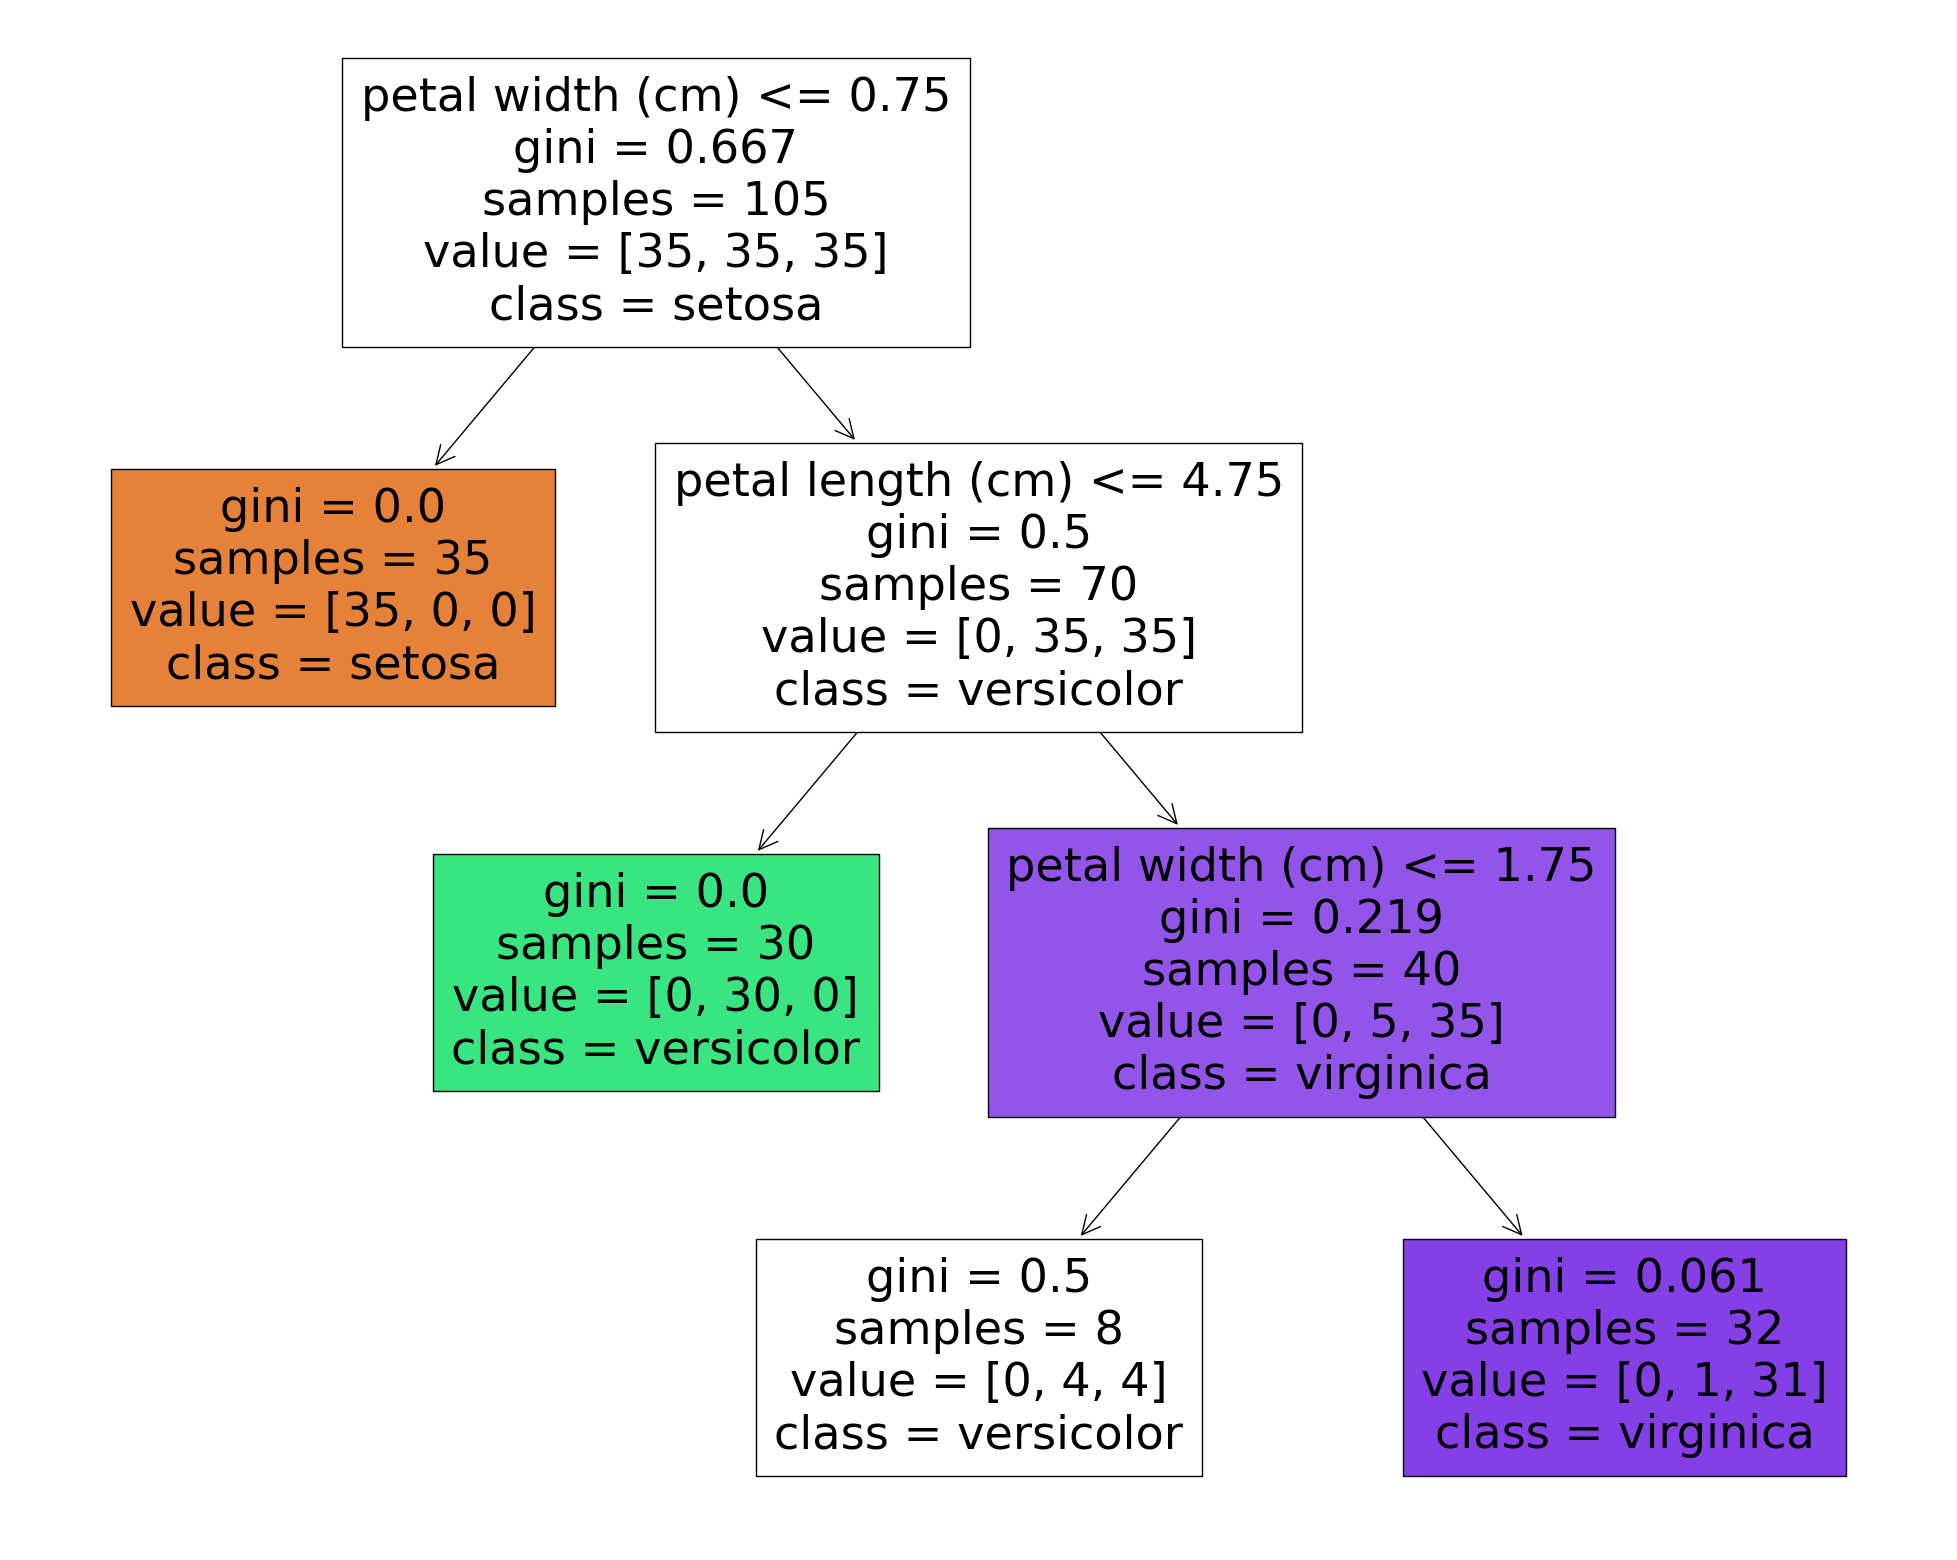

In [91]:
from sklearn.tree import plot_tree
fig = plt.figure(figsize=(25,20))
_ = plot_tree(tree, 
                   feature_names=iris.feature_names[2:],  
                   class_names=iris.target_names,
                   filled=True)

## 3. SVM 써보기

/tmp/ipykernel_829184/608533853.py:19: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y==cl,0], y=X[y==cl,1],


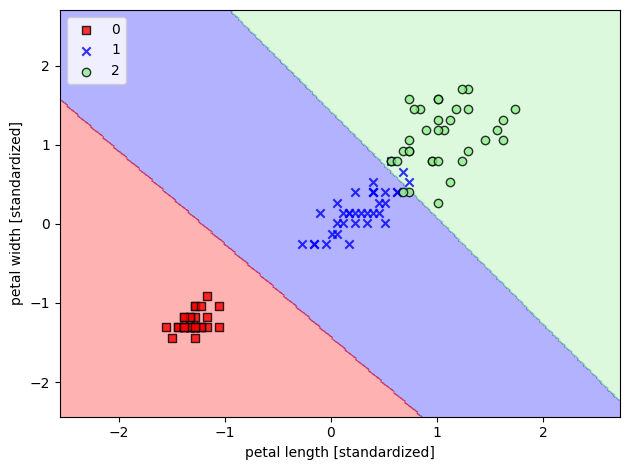

In [139]:
from sklearn.svm import SVC

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

svm = SVC(kernel='linear',C=100)
svm.fit(X_train_std, y_train)
 
plot_decision_regions(X_train_std, 
                      y_train,
                      classifier=svm, 
                      resolution = 0.02)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

/tmp/ipykernel_829184/608533853.py:19: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y==cl,0], y=X[y==cl,1],


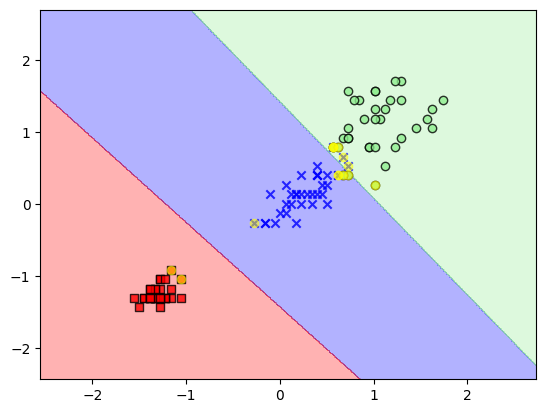

In [140]:
plot_decision_regions(X_train_std, 
                      y_train,
                      classifier=svm, resolution = 0.01)
plt.scatter(svm.support_vectors_[:,0],svm.support_vectors_[:,1],c='yellow', alpha=0.5)

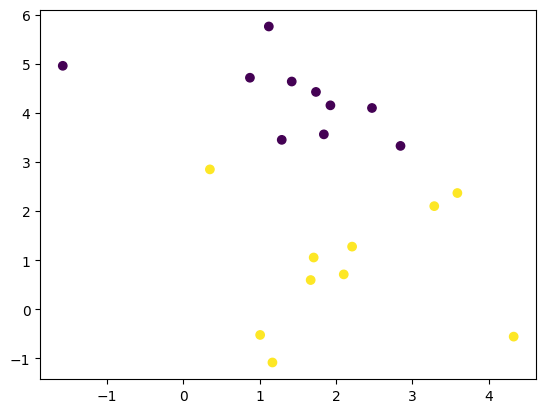

In [142]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=20, centers=2, n_features=2,random_state=0)
plt.scatter(X[:,0],X[:,1], c=y)

/tmp/ipykernel_829184/608533853.py:19: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y==cl,0], y=X[y==cl,1],


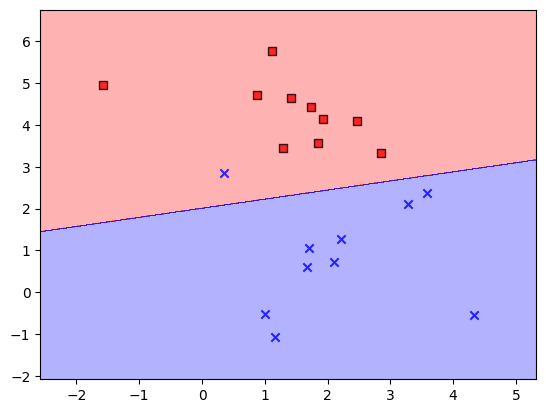

In [143]:
svm = SVC(kernel='linear', C=0.001, random_state=1)# c는 틀린 것에대한 로스 크기 (c가 작으면 오차는 허용하고 마진 크게)(c가 크면 오차 허용x 마진 작게)
svm.fit(X, y)
 
plot_decision_regions(X, 
                      y,
                      classifier=svm, resolution=0.01)

/tmp/ipykernel_829184/608533853.py:19: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y==cl,0], y=X[y==cl,1],


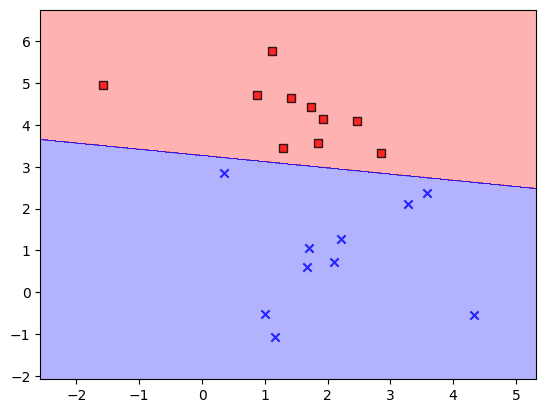

In [144]:
svm = SVC(kernel='linear', C=1000, random_state=1)
svm.fit(X, y)
 
plot_decision_regions(X, 
                      y,
                      classifier=svm, resolution=0.01)

## 4. Kernel SVM을 이용한 비선형 분류

In [145]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)


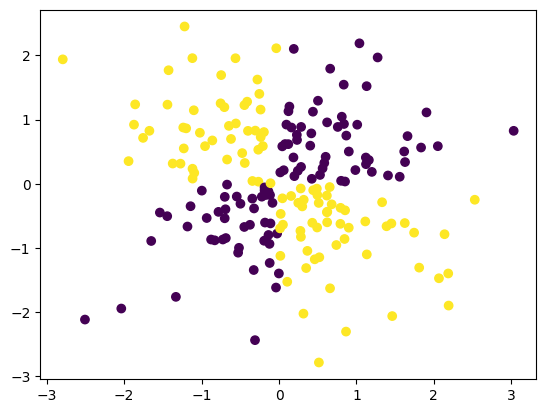

In [146]:
plt.scatter(X_xor[:,0], X_xor[:,1] , c=y_xor)

/tmp/ipykernel_829184/608533853.py:19: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y==cl,0], y=X[y==cl,1],


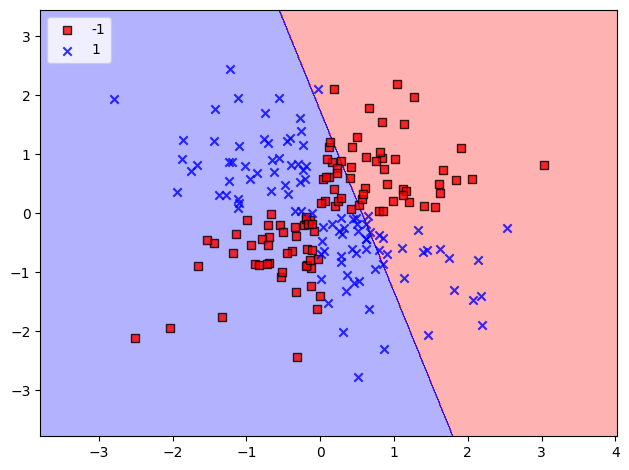

In [147]:
svm = SVC(kernel='linear', random_state=1, C=0.0001)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor,
                      classifier=svm, resolution=0.01)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

/tmp/ipykernel_829184/608533853.py:19: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y==cl,0], y=X[y==cl,1],


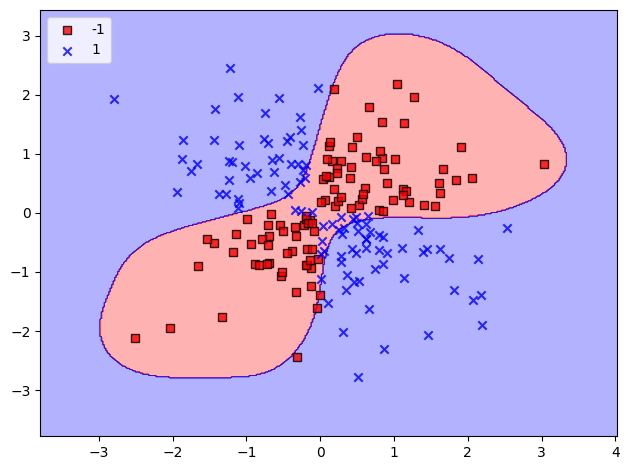

In [150]:
svm = SVC(kernel='rbf', random_state=1, gamma=1, C=0.01)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor,
                      classifier=svm, resolution=0.02)
#plt.scatter(svm.support_vectors_[:,0],svm.support_vectors_[:,1],c='k', alpha=0.5)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

/tmp/ipykernel_829184/608533853.py:19: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y==cl,0], y=X[y==cl,1],


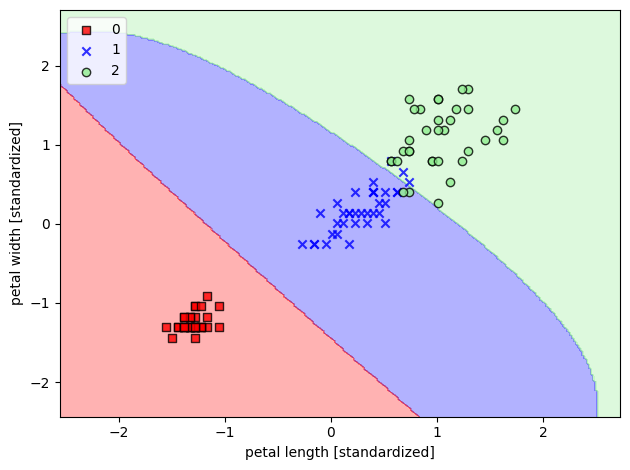

In [157]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_train_std,y_train,
                      classifier=svm, resolution=0.02)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

/tmp/ipykernel_829184/608533853.py:19: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y==cl,0], y=X[y==cl,1],


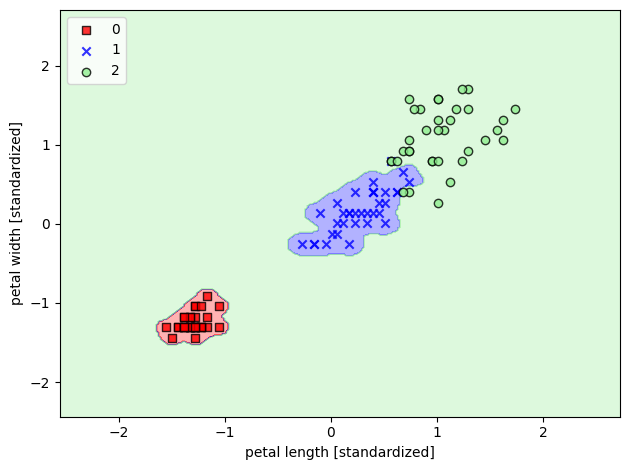

In [162]:
svm = SVC(kernel='rbf', random_state=1, gamma=100.0, C=1.0)#gamma: 감마가 커질 수록 데이터 군에 적응(크면 데이터의 테두리를 두르는 정도, 작으면 크게크게 선 그음)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_train_std, y_train, 
                      classifier=svm, resolution=0.02)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

/tmp/ipykernel_829184/608533853.py:19: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y==cl,0], y=X[y==cl,1],


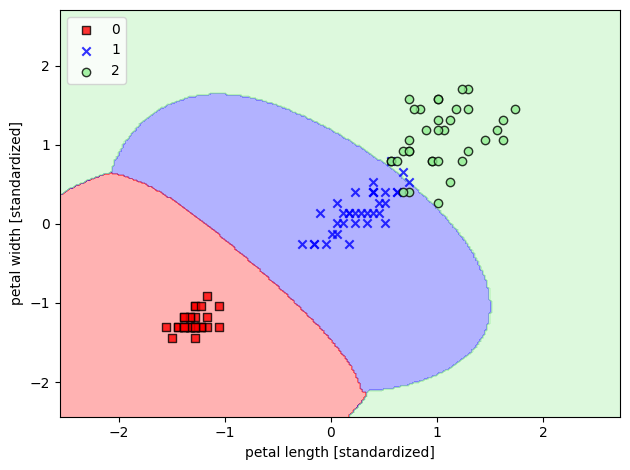

In [159]:
svm = SVC(kernel='rbf', random_state=1, gamma=0.5, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_train_std, y_train, 
                      classifier=svm, resolution=0.02)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()